# Convolutional Neural Networks

As a practical example, we are going to implement a ConvNet in `PyTorch`. Again, we start by importing all necessary libraries.

You can observe that the code structure stays the same! 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1 Define hyperparameters

We define some of the hyperparameters beforehand.

In [2]:
learning_rate = .01
batch_size = 64
test_batch_size = 1000
n_epochs = 5

## 2 Define model

Our CNN will have two convolutional layers, followed by a ReLU unit and by Max Pooling. On top of the convolutional layers, there will be two fully connected layers. The output is then mapped through a Softmax activation function as before.

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


 ## 3 Loss function and optimiser

In [4]:
lossfunction = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate)

## 4 Load Data

In [5]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True)

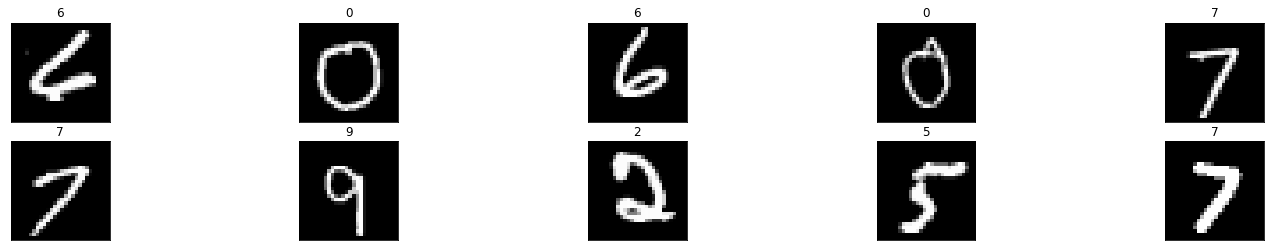

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

## 5 Train the network
Now we want to compare the accuracy of the CNN with the accuracy achieved using a multilayer perceptron. 

As a difference to before, we choose smaller batches and 

In [7]:
for epoch in range(n_epochs):
    
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()

        output = model(data)

        loss = lossfunction(output, target)

        loss.backward()

        optimizer.step()

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch+1, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
    
    
    # test
    model.eval()

    test_loss = 0

    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # sum up batch loss
            test_loss += lossfunction(output, target).item()

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability

            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('    Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.053702
    Test set: Average loss: 0.0002, Accuracy: 9532/10000 (95%)

Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.042163
    Test set: Average loss: 0.0001, Accuracy: 9753/10000 (98%)

Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.179275
    Test set: Average loss: 0.0001, Accuracy: 9755/10000 (98%)

Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.029161
    Test set: Average loss: 0.0001, Accuracy: 9822/10000 (98%)

Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.023034
    Test set: Average loss: 0.0000, Accuracy: 9855/10000 (99%)



# Prediction

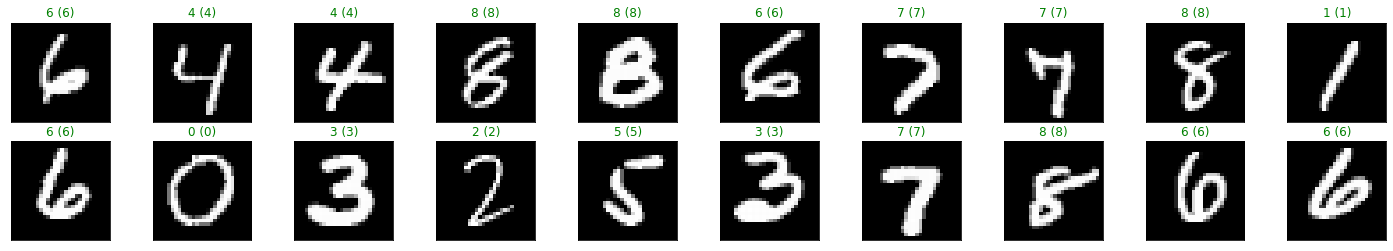

In [8]:
# obtain test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# load an image
output = model(images)
# compute predicted class from NN output
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))